In [5]:
from yahoo_finance import Share
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#yahoo = Share("AMZN")
#price_history = yahoo.get_historical('2010-01-01', '2017-01-01')

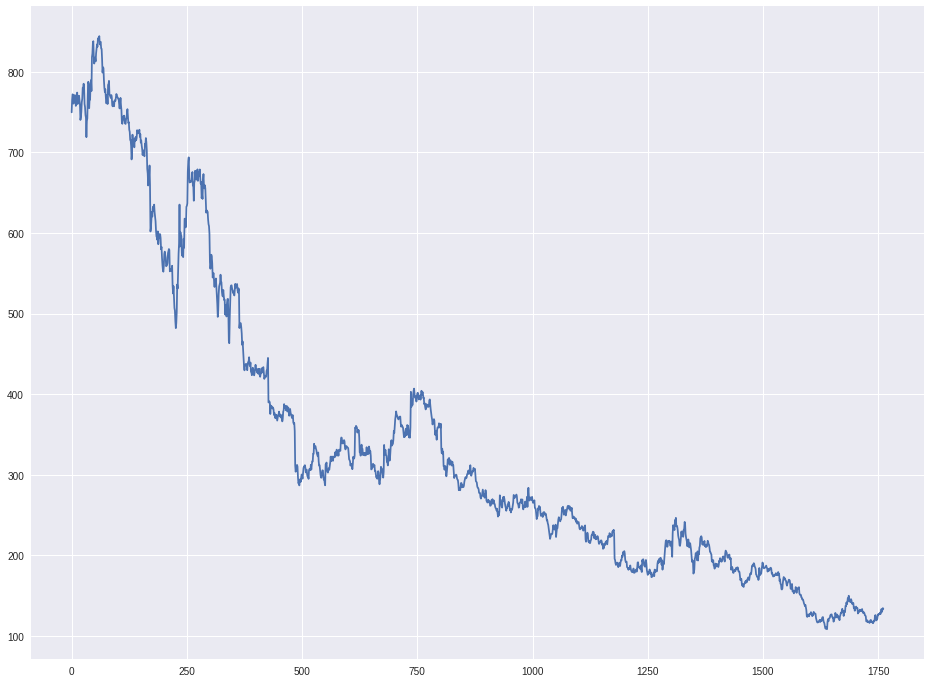

In [13]:
close_price = [ day['Adj_Close'] for day in price_history]
date = [ day['Date'] for day in price_history]

data = pd.DataFrame(dict(price=close_price, date=date))
data['date']  = pd.to_datetime(data.date)

_ = plt.figure(figsize = (16,12))
plt.plot(data['price'])

In [56]:
#create lagging for training with time-step

lag = 5

def create_lag(p, lag):
    ret = []
    for i in range(lag + 1):
        ret.append(p.shift(i).values.reshape(-1, 1))
    label = ret.pop(0)
    #fill NA value with 0
    data = np.hstack(ret).astype(np.float32)
    data[np.isnan(data)] = 0
    #reshape for LSTM training
    data = data.reshape(data.shape[0], data.shape[1], 1)
    return data, label

X, Y = create_lag(data.price, lag)


In [72]:
#stateless LSTM 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = "weights.{epoch:02d}-{mean_squared_error:.2f}.hdf5"
check_point = ModelCheckpoint(filepath, monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='mean_squared_error', patience=3, verbose=0)
call_backs = [early_stopping, early_stopping]

n_sample = X.shape[0]
n_step = X.shape[1]

def build_stateless():
    model = Sequential()
    model.add(LSTM(32, input_shape=(n_step, 1),))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = build_stateless()
model.fit(X, Y, nb_epoch=5, verbose=1, batch_size=32)

Epoch 1/5
1762/1762 [==============================] - 0s - loss: 149358.2379     
Epoch 2/5
1762/1762 [==============================] - 0s - loss: 149077.6612     